# Recap of second order Trotter results
Recap notebook for second order Trotter results.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from iminuit import Minuit
from iminuit.cost import LeastSquares  

## My functions
All the functions I wrote to compute commutators numerically and other support functions.

In [2]:
def gen_Heisenberg_terms(N):
        XY = [] 
        XZ = []   
        YZ = [] 

        for i in range(N):
            for j in range(i+1, N):
                gate_id = f"g{i+1}{j+1}" 

                xx_term = ["X" if k == i or k == j else "I" for k in range(N)]
                yy_term = ["Y" if k == i or k == j else "I" for k in range(N)]
                zz_term = ["Z" if k == i or k == j else "I" for k in range(N)]

                XY.append((0.5, gate_id, "".join(xx_term)))
                XY.append((0.5, gate_id, "".join(yy_term)))

                XZ.append((0.5, gate_id, "".join(xx_term)))
                XZ.append((0.5, gate_id, "".join(zz_term)))

                YZ.append((0.5, gate_id, "".join(yy_term)))
                YZ.append((0.5, gate_id, "".join(zz_term)))

        return XY, XZ, YZ

In [3]:
pauli_mult_table = {
    ('I', 'I'): (1, 'I'),
    ('I', 'X'): (1, 'X'),
    ('I', 'Y'): (1, 'Y'),
    ('I', 'Z'): (1, 'Z'),
    ('X', 'I'): (1, 'X'),
    ('Y', 'I'): (1, 'Y'),
    ('Z', 'I'): (1, 'Z'),
    ('X', 'X'): (1, 'I'),
    ('Y', 'Y'): (1, 'I'),
    ('Z', 'Z'): (1, 'I'),
    ('Y', 'Z'): (+1j, 'X'),
    ('X', 'Y'): (+1j, 'Z'),
    ('Z', 'X'): (+1j, 'Y'),
    ('Y', 'X'): (-1j, 'Z'),
    ('Z', 'Y'): (-1j, 'X'),
    ('X', 'Z'): (-1j, 'Y'),
    ('0', 'I'): (0, '0'),
    ('0', 'X'): (0, '0'),
    ('0', 'Y'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('I', '0'): (0, '0'),
    ('X', '0'): (0, '0'),
    ('Y', '0'): (0, '0'),
    ('Z', '0'): (0, '0')
}

In [4]:
def comm_pstr(pstr1, pstr2):
    """
    `comm_pstr(self, pstr1, pstr2)`
    pstr1, pstr2 (tuple): (numeric coefficient, couplings, individual Pauli string)

    comm_pstr function computes the commutator [pstr1, pstr2], keeping track of resulting numeric coefficient and coupling combination.
    return: (numeric coefficient, couplings, individual Pauli string) (tuple)
    """
    ps1 = pstr1[2] # e.g. "IXX"
    ps2 = pstr2[2] # e.g. "YIY"

    coeff = pstr1[0] * pstr2[0]
    psfinal = ""
    acomm_cnt = 0

    for i in range(len(ps1)):
        p1 = ps1[i]
        p2 = ps2[i]

        if p1 != p2 and p1 != 'I' and p2 != 'I': acomm_cnt += 1

        pair = pauli_mult_table[(p1, p2)]
        coeff = coeff * pair[0]
        psfinal += pair[1]

    if acomm_cnt % 2 == 0 or '0' in psfinal:
        return (0, "", '0'*len(ps1))
    
    return (2*coeff, f"({pstr1[1]})({pstr2[1]})", psfinal) # factor of 2 is introduced here

In [5]:
def comm_lincombo(psum1, psum2):
    """
    `comm_lincombo(self, psum1, psum2)`
    psum1, psum2 (list of tuples): [(numeric coefficient 1, couplings 1, individual Pauli string 1), ...]

    comm_lincombo computes the commutator of two sums of Pauli strings, keeping track of numerical coefficients and coupling powers.
    return: [(resulting numeric coefficient 1, resulting couplings 1, resulting individual Pauli string 1), ...] (list of tuples)
    """
    list_comm = []

    for elem1 in psum1:
        for elem2 in psum2:
            res = comm_pstr(elem1, elem2)
            if '0' not in res[2]: list_comm.append((res[0], res[1], res[2]))

    return list_comm

In [6]:
def group_by_pauli_string(comm, N):
    """
    `group_by_pauli_string(comm, N)`
    comm (list of tuples): [(numeric coefficient, couplings, Pauli string), ...]
    N (int)              : number of qubits

    group_by_pauli_string groups terms with the same Pauli string, and within those terms sums
    contributions with the same coupling coefficient

    return: dict {Pauli string: [[coefficient, coupling], ...], ...} 
    """

    def is_coeff_equal(str1, str2):
        pair1 = str1.split(")(")        
        pair2 = str2.split(")(")
        pair1 = [p.strip('(').strip(')').strip('g') for p in pair1]
        pair2 = [p.strip('(').strip(')').strip('g') for p in pair2]

        return sorted(pair1) == sorted(pair2)
        
    list_terms = {}
    for term in comm:
        if term[2] != "0"*N:
            if term[2] not in list_terms:
                list_terms[term[2]] = [[term[0], term[1]]]
            else:
                cnt_not = 0 
                for i, elem in enumerate(list_terms[term[2]]):
                    if is_coeff_equal(term[1], elem[1]):
                        list_terms[term[2]][i][0] += elem[0] # refactor coefficient
                    else:
                        cnt_not +=1 
                if cnt_not == len(list_terms[term[2]]): list_terms[term[2]].append([term[0], term[1]]) # TODO can it be changed to ([term[0], term[1])?

    return list_terms

In [7]:
values_N = np.arange(3,9)

A3, B3, C3 = gen_Heisenberg_terms(3)
A4, B4, C4 = gen_Heisenberg_terms(4)
A5, B5, C5 = gen_Heisenberg_terms(5)
A6, B6, C6 = gen_Heisenberg_terms(6)
A7, B7, C7 = gen_Heisenberg_terms(7)
A8, B8, C8 = gen_Heisenberg_terms(8)



A3B3 = comm_lincombo(A3, B3)
A3C3 = comm_lincombo(A3, C3)
B3C3 = comm_lincombo(B3, C3)
B3A3 = comm_lincombo(B3, A3)
C3A3 = comm_lincombo(C3, A3)
C3B3 = comm_lincombo(C3, B3)

A4B4 = comm_lincombo(A4, B4)
A4C4 = comm_lincombo(A4, C4)
B4C4 = comm_lincombo(B4, C4)
B4A4 = comm_lincombo(B4, A4)
C4A4 = comm_lincombo(C4, A4)
C4B4 = comm_lincombo(C4, B4)

A5B5 = comm_lincombo(A5, B5)
A5C5 = comm_lincombo(A5, C5)
B5C5 = comm_lincombo(B5, C5)
B5A5 = comm_lincombo(B5, A5)
C5A5 = comm_lincombo(C5, A5)
C5B5 = comm_lincombo(C5, B5)

A6B6 = comm_lincombo(A6, B6)
A6C6 = comm_lincombo(A6, C6)
B6C6 = comm_lincombo(B6, C6)
B6A6 = comm_lincombo(B6, A6)
C6A6 = comm_lincombo(C6, A6)
C6B6 = comm_lincombo(C6, B6) 

A7B7 = comm_lincombo(A7, B7)
A7C7 = comm_lincombo(A7, C7)
B7C7 = comm_lincombo(B7, C7)
B7A7 = comm_lincombo(B7, A7)
C7A7 = comm_lincombo(C7, A7)
C7B7 = comm_lincombo(C7, B7) 

A8B8 = comm_lincombo(A8, B8)
A8C8 = comm_lincombo(A8, C8)
B8C8 = comm_lincombo(B8, C8)
B8A8 = comm_lincombo(B8, A8)
C8A8 = comm_lincombo(C8, A8)
C8B8 = comm_lincombo(C8, B8) 


# 1/12
B3_B3A3 = comm_lincombo(B3, B3A3)
B3_C3A3 = comm_lincombo(B3, C3A3)
C3_B3A3 = comm_lincombo(C3, B3A3)
C3_C3A3 = comm_lincombo(C3, C3A3)
C3_C3B3 = comm_lincombo(C3, C3B3)
# 1/24
A3_A3B3 = comm_lincombo(A3, A3B3)
A3_A3C3 = comm_lincombo(A3, A3C3)
B3_B3C3 = comm_lincombo(B3, B3C3)
    
# 1/12
B4_B4A4 = comm_lincombo(B4, B4A4)
B4_C4A4 = comm_lincombo(B4, C4A4)
C4_B4A4 = comm_lincombo(C4, B4A4)
C4_C4A4 = comm_lincombo(C4, C4A4)
C4_C4B4 = comm_lincombo(C4, C4B4)
# 1/24
A4_A4B4 = comm_lincombo(A4, A4B4)
A4_A4C4 = comm_lincombo(A4, A4C4)
B4_B4C4 = comm_lincombo(B4, B4C4)

# 1/12
B5_B5A5 = comm_lincombo(B5, B5A5)
B5_C5A5 = comm_lincombo(B5, C5A5)
C5_B5A5 = comm_lincombo(C5, B5A5)
C5_C5A5 = comm_lincombo(C5, C5A5)
C5_C5B5 = comm_lincombo(C5, C5B5)
# 1/24
A5_A5B5 = comm_lincombo(A5, A5B5)
A5_A5C5 = comm_lincombo(A5, A5C5)
B5_B5C5 = comm_lincombo(B5, B5C5)

# 1/12
B6_B6A6 = comm_lincombo(B6, B6A6)
B6_C6A6 = comm_lincombo(B6, C6A6)
C6_B6A6 = comm_lincombo(C6, B6A6)
C6_C6A6 = comm_lincombo(C6, C6A6)
C6_C6B6 = comm_lincombo(C6, C6B6)
# 1/24
A6_A6B6 = comm_lincombo(A6, A6B6)
A6_A6C6 = comm_lincombo(A6, A6C6)
B6_B6C6 = comm_lincombo(B6, B6C6)

# 1/12
B7_B7A7 = comm_lincombo(B7, B7A7)
B7_C7A7 = comm_lincombo(B7, C7A7)
C7_B7A7 = comm_lincombo(C7, B7A7)
C7_C7A7 = comm_lincombo(C7, C7A7)
C7_C7B7 = comm_lincombo(C7, C7B7)
# 1/24
A7_A7B7 = comm_lincombo(A7, A7B7)
A7_A7C7 = comm_lincombo(A7, A7C7)
B7_B7C7 = comm_lincombo(B7, B7C7)

# 1/12
B8_B8A8 = comm_lincombo(B8, B8A8)
B8_C8A8 = comm_lincombo(B8, C8A8)
C8_B8A8 = comm_lincombo(C8, B8A8)
C8_C8A8 = comm_lincombo(C8, C8A8)
C8_C8B8 = comm_lincombo(C8, C8B8)
# 1/24
A8_A8B8 = comm_lincombo(A8, A8B8)
A8_A8C8 = comm_lincombo(A8, A8C8)
B8_B8C8 = comm_lincombo(B8, B8C8)

# N=3
terms_B3_C3A3 = group_by_pauli_string(B3_C3A3, N=3)
terms_B3_B3A3 = group_by_pauli_string(B3_B3A3, N=3)
terms_C3_C3A3 = group_by_pauli_string(C3_C3A3, N=3)
terms_C3_B3A3 = group_by_pauli_string(C3_B3A3, N=3)
terms_A3_A3B3 = group_by_pauli_string(A3_A3B3, N=3)
terms_C3_C3B3 = group_by_pauli_string(C3_C3B3, N=3)
terms_B3_B3C3 = group_by_pauli_string(B3_B3C3, N=3)
terms_A3_A3C3 = group_by_pauli_string(A3_A3C3, N=3)

# N=4
terms_B4_C4A4 = group_by_pauli_string(B4_C4A4, N=4)
terms_B4_B4A4 = group_by_pauli_string(B4_B4A4, N=4)
terms_C4_C4A4 = group_by_pauli_string(C4_C4A4, N=4)
terms_C4_B4A4 = group_by_pauli_string(C4_B4A4, N=4)
terms_A4_A4B4 = group_by_pauli_string(A4_A4B4, N=4)
terms_C4_C4B4 = group_by_pauli_string(C4_C4B4, N=4)
terms_B4_B4C4 = group_by_pauli_string(B4_B4C4, N=4)
terms_A4_A4C4 = group_by_pauli_string(A4_A4C4, N=4)
    
# N=5
terms_B5_C5A5 = group_by_pauli_string(B5_C5A5, N=5)
terms_B5_B5A5 = group_by_pauli_string(B5_B5A5, N=5)
terms_C5_C5A5 = group_by_pauli_string(C5_C5A5, N=5)
terms_C5_B5A5 = group_by_pauli_string(C5_B5A5, N=5)
terms_A5_A5B5 = group_by_pauli_string(A5_A5B5, N=5)
terms_C5_C5B5 = group_by_pauli_string(C5_C5B5, N=5)
terms_B5_B5C5 = group_by_pauli_string(B5_B5C5, N=5)
terms_A5_A5C5 = group_by_pauli_string(A5_A5C5, N=5)

# N=6
terms_B6_C6A6 = group_by_pauli_string(B6_C6A6, N=6)
terms_B6_B6A6 = group_by_pauli_string(B6_B6A6, N=6)
terms_C6_C6A6 = group_by_pauli_string(C6_C6A6, N=6)
terms_C6_B6A6 = group_by_pauli_string(C6_B6A6, N=6)
terms_A6_A6B6 = group_by_pauli_string(A6_A6B6, N=6)
terms_C6_C6B6 = group_by_pauli_string(C6_C6B6, N=6)
terms_B6_B6C6 = group_by_pauli_string(B6_B6C6, N=6)
terms_A6_A6C6 = group_by_pauli_string(A6_A6C6, N=6)

# N=7
terms_B7_C7A7 = group_by_pauli_string(B7_C7A7, N=7)
terms_B7_B7A7 = group_by_pauli_string(B7_B7A7, N=7)
terms_C7_C7A7 = group_by_pauli_string(C7_C7A7, N=7)
terms_C7_B7A7 = group_by_pauli_string(C7_B7A7, N=7)
terms_A7_A7B7 = group_by_pauli_string(A7_A7B7, N=7)
terms_C7_C7B7 = group_by_pauli_string(C7_C7B7, N=7)
terms_B7_B7C7 = group_by_pauli_string(B7_B7C7, N=7)
terms_A7_A7C7 = group_by_pauli_string(A7_A7C7, N=7)

# N=8
terms_B8_C8A8 = group_by_pauli_string(B8_C8A8, N=8)
terms_B8_B8A8 = group_by_pauli_string(B8_B8A8, N=8)
terms_C8_C8A8 = group_by_pauli_string(C8_C8A8, N=8)
terms_C8_B8A8 = group_by_pauli_string(C8_B8A8, N=8)
terms_A8_A8B8 = group_by_pauli_string(A8_A8B8, N=8)
terms_C8_C8B8 = group_by_pauli_string(C8_C8B8, N=8)
terms_B8_B8C8 = group_by_pauli_string(B8_B8C8, N=8)
terms_A8_A8C8 = group_by_pauli_string(A8_A8C8, N=8)

terms12_3 = [terms_B3_B3A3, terms_B3_C3A3, terms_C3_B3A3, terms_C3_C3A3, terms_C3_C3B3]
terms12_4 = [terms_B4_B4A4, terms_B4_C4A4, terms_C4_B4A4, terms_C4_C4A4, terms_C4_C4B4] 
terms12_5 = [terms_B5_B5A5, terms_B5_C5A5, terms_C5_B5A5, terms_C5_C5A5, terms_C5_C5B5] 
terms12_6 = [terms_B6_B6A6, terms_B6_C6A6, terms_C6_B6A6, terms_C6_C6A6, terms_C6_C6B6] 
terms12_7 = [terms_B7_B7A7, terms_B7_C7A7, terms_C7_B7A7, terms_C7_C7A7, terms_C7_C7B7] 
terms12_8 = [terms_B8_B8A8, terms_B8_C8A8, terms_C8_B8A8, terms_C8_C8A8, terms_C8_C8B8] 


terms24_3 = [terms_A3_A3B3, terms_A3_A3C3, terms_B3_B3C3]
terms24_4 = [terms_A4_A4B4, terms_A4_A4C4, terms_B4_B4C4]
terms24_5 = [terms_A5_A5B5, terms_A5_A5C5, terms_B5_B5C5]
terms24_6 = [terms_A6_A6B6, terms_A6_A6C6, terms_B6_B6C6]
terms24_7 = [terms_A7_A7B7, terms_A7_A7C7, terms_B7_B7C7]
terms24_8 = [terms_A8_A8B8, terms_A8_A8C8, terms_B8_B8C8]

In [8]:
def fixed_t_commsum_T2(onetwo, twofour, couplings, t):
    """
    onetwo  (list of dicts): [{"XYZ": [[-0.5j, "(g12)(g23)"], ...], ...}, {"XYZ": [[0.5j, "(g12)(g13)"], ...], ...}]; these are the terms that contribute with 1/12 coeff
    twofour (list of dicts): [{"XYZ": [[-0.5j, "(g12)(g23)"], ...], ...}, {"XYZ": [[0.5j, "(g12)(g13)"], ...], ...}]; these are the terms that contribute with 1/24 coeff
    couplings (dict): {"g12": 0.1, "g13": 0.2, ...}
    t (float): time length of simulation

    Implements second order Trotter formula for the Trotter error.

    return: value of first order Trotter error for a given set of couplings and time.  
    """
    def format_couplings(s):
        coupl = s.replace('(', '').replace(')','')
        coupl = coupl.split('g')
        coupl = ['g'+pair for pair in coupl if pair != '']
        return coupl


    def eval_couplings(coeff_str, coupl_dict):
        split_str = format_couplings(coeff_str)

        prod = 1
        for term in split_str:
            prod *= coupl_dict[term]
            
        return prod
    
    # err_vl = 1/12 * sum (g coeff)||Pauli string||(=1) * dt^3 + 1/24 * sum (g coeff)||Pauli string||(=1) * dt^3 (TODO check)
    err_vl = 0

    err_12 = 0
    for comm_dict in onetwo:
        for _, terms in comm_dict.items():
            coeff = 0
            for term in terms:
                if term[1] != '': coeff += abs(term[0]) * eval_couplings(term[1], couplings)
            err_12 += abs(coeff)

    err_vl += err_12 * t**3 / 12

    err_24 = 0
    for comm_dict in twofour:
        for _, terms in comm_dict.items():
            coeff = 0
            for term in terms:
                if term[1] != '': coeff += abs(term[0]) * eval_couplings(term[1], couplings)
            err_24 += abs(coeff)

    err_vl += err_24 * t**3 / 24

    return err_vl

In [9]:
mu = 1 * 1e2

def theta_nu(N, i, j, vl):
    return np.arccos(vl) * abs(i-j) / (N-1)

def fp_couplings(N, peakness): # fp = forward peaked
    """
    N (int): number of neutrinos
    peakness (float): in [-1,1)
    """
    if peakness < -1 or peakness >= 1: raise Exception(f"Value of peakness argument must be in [-1,1) interval, but {peakness} ins't.")
    coupl_dic = {}
    angle_dic = {}
    for i in range(N):
        for j in range(i+1, N):
            angle_dic[f"g{i+1}{j+1}"] = theta_nu(N, i, j, peakness)
            coupl_dic[f"g{i+1}{j+1}"] = mu * (1-np.cos(theta_nu(N, i, j, peakness))) / N

    return coupl_dic, angle_dic

def Theta(angles):
    return max(1 - np.cos(angle) for angle in angles.values())

## Models

In [10]:
def model_T2(x, gamma2, K2):
    return mu**3 * K2 * x**gamma2 / 96

def model_T2_m2(x, gammap2, Kp2):
    return mu**3 * Kp2 * x**(gammap2-2) / 96

## Analysis
The aim of the analysis is to determine a bound for the first order Trotter error of my simulation by fitting the scaling law coefficients for the various parameters of the system of interest: a peaked neutrino beam.

I focus on fitting the $N$ dependance of the bound.

I propose the following model for the second order Trotter error:
$$
\mathcal{F}\left(dt,N,\{g_{ij}\}; K_2, \gamma_2\right)=\frac{1}{96}K_2\mu^3\Theta^3dt^3N^{\gamma_2}
$$
where $\Theta=\text{max}_{i,j}[1-\cos\theta_{ij}]$, $\theta_{ij}=\arccos(\upsilon)\frac{|i-j|}{N-1}$, with $\upsilon\in[-1,1)$; I call $\upsilon$ the _peakness_ parameter.

peakness = -1.0; dt = 0.01
peakness = -1.0; dt = 0.02
peakness = -1.0; dt = 0.03
peakness = -1.0; dt = 0.04
peakness = -1.0; dt = 0.05
peakness = -1.0; dt = 0.06
peakness = -1.0; dt = 0.07
peakness = -1.0; dt = 0.08
peakness = -1.0; dt = 0.09
peakness = -0.99; dt = 0.01
peakness = -0.99; dt = 0.02
peakness = -0.99; dt = 0.03
peakness = -0.99; dt = 0.04
peakness = -0.99; dt = 0.05
peakness = -0.99; dt = 0.06
peakness = -0.99; dt = 0.07
peakness = -0.99; dt = 0.08
peakness = -0.99; dt = 0.09
peakness = -0.98; dt = 0.01
peakness = -0.98; dt = 0.02
peakness = -0.98; dt = 0.03
peakness = -0.98; dt = 0.04
peakness = -0.98; dt = 0.05
peakness = -0.98; dt = 0.06
peakness = -0.98; dt = 0.07
peakness = -0.98; dt = 0.08
peakness = -0.98; dt = 0.09
peakness = -0.97; dt = 0.01
peakness = -0.97; dt = 0.02
peakness = -0.97; dt = 0.03
peakness = -0.97; dt = 0.04
peakness = -0.97; dt = 0.05
peakness = -0.97; dt = 0.06
peakness = -0.97; dt = 0.07
peakness = -0.97; dt = 0.08
peakness = -0.97; dt = 0.09
p

C:\Users\edori\AppData\Local\Temp\ipykernel_4512\2678080671.py:2: RuntimeWarning: overflow encountered in power
  return mu**3 * K2 * x**gamma2 / 96
c:\Users\edori\AppData\Local\Programs\Python\Python313\Lib\site-packages\iminuit\cost.py:172: RuntimeWarning: overflow encountered in multiply
  return z * z


peakness = 0.01; dt = 0.02
peakness = 0.01; dt = 0.03
peakness = 0.01; dt = 0.04
peakness = 0.01; dt = 0.05
peakness = 0.01; dt = 0.06
peakness = 0.01; dt = 0.07
peakness = 0.01; dt = 0.08
peakness = 0.01; dt = 0.09
peakness = 0.02; dt = 0.01
peakness = 0.02; dt = 0.02
peakness = 0.02; dt = 0.03
peakness = 0.02; dt = 0.04
peakness = 0.02; dt = 0.05
peakness = 0.02; dt = 0.06
peakness = 0.02; dt = 0.07
peakness = 0.02; dt = 0.08
peakness = 0.02; dt = 0.09
peakness = 0.03; dt = 0.01
peakness = 0.03; dt = 0.02
peakness = 0.03; dt = 0.03
peakness = 0.03; dt = 0.04
peakness = 0.03; dt = 0.05
peakness = 0.03; dt = 0.06
peakness = 0.03; dt = 0.07
peakness = 0.03; dt = 0.08
peakness = 0.03; dt = 0.09
peakness = 0.04; dt = 0.01
peakness = 0.04; dt = 0.02
peakness = 0.04; dt = 0.03
peakness = 0.04; dt = 0.04
peakness = 0.04; dt = 0.05
peakness = 0.04; dt = 0.06
peakness = 0.04; dt = 0.07
peakness = 0.04; dt = 0.08
peakness = 0.04; dt = 0.09
peakness = 0.05; dt = 0.01
peakness = 0.05; dt = 0.02
p

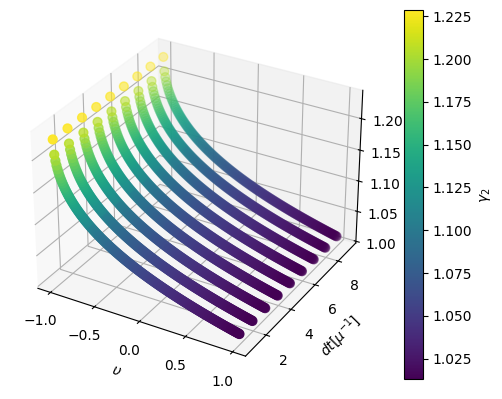

In [11]:
peakness_vls = np.arange(-100,100) * 1e-2
slopes_altfit = []
dt_list = np.arange(1,10) / mu

xs_altfit = []
ys_altfit = []
zs_altfit = []
Ks = []

for peak in peakness_vls:
    for dt in dt_list:
        print(f"peakness = {peak}; dt = {dt}")
        err_vls_dt = []

        couplings3, angles3 = fp_couplings(3, peak)
        couplings4, angles4 = fp_couplings(4, peak)
        couplings5, angles5 = fp_couplings(5, peak)
        couplings6, angles6 = fp_couplings(6, peak)
        couplings7, angles7 = fp_couplings(7, peak)
        couplings8, angles8 = fp_couplings(8, peak)

        err_vls_dt.append(fixed_t_commsum_T2(terms12_3, terms24_3, couplings3, dt)/dt**3/Theta(angles3)**3)
        err_vls_dt.append(fixed_t_commsum_T2(terms12_4, terms24_4, couplings4, dt)/dt**3/Theta(angles4)**3)
        err_vls_dt.append(fixed_t_commsum_T2(terms12_5, terms24_5, couplings5, dt)/dt**3/Theta(angles5)**3)
        err_vls_dt.append(fixed_t_commsum_T2(terms12_6, terms24_6, couplings6, dt)/dt**3/Theta(angles6)**3)
        err_vls_dt.append(fixed_t_commsum_T2(terms12_7, terms24_7, couplings7, dt)/dt**3/Theta(angles7)**3)
        err_vls_dt.append(fixed_t_commsum_T2(terms12_8, terms24_8, couplings8, dt)/dt**3/Theta(angles8)**3)

        ls_obj = LeastSquares(values_N, err_vls_dt, 0.001, model_T2)
        m_obj = Minuit(ls_obj, gamma2=0.5, K2=1)
        m_obj.migrad()
        m_obj.hesse()

        slopes_altfit.append(m_obj.values[0])
        xs_altfit.append(peak)
        ys_altfit.append(dt*mu)
        zs_altfit.append(m_obj.values[0])   
        Ks.append(m_obj.values[1])      


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs_altfit, ys_altfit, zs_altfit, c=zs_altfit, cmap="viridis", s=40)

ax.set_xlabel(r"$\upsilon$")
ax.set_ylabel(r"$dt[\mu^{-1}]$")
ax.set_zlabel(r"$\gamma$")
fig.colorbar(scatter, ax=ax, label=r"$\gamma_2$")

plt.savefig(f"C:\\Users\\edori\\Desktop\\Nexus\\Università\\Current\\MasterThesis\\stand_hub\\stand\\presentations\\T2gamma.pdf", dpi=300)
plt.show()

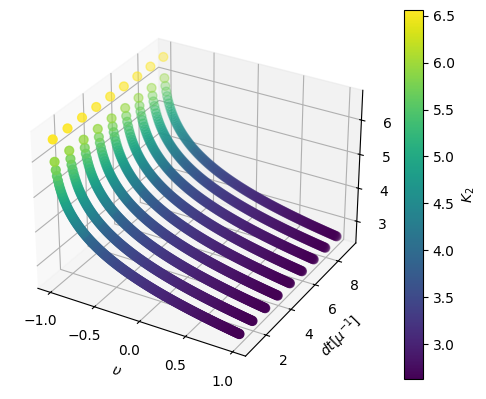

In [12]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(xs_altfit, ys_altfit, Ks, c=Ks, cmap="viridis", s=40)

ax.set_xlabel(r"$\upsilon$")
ax.set_ylabel(r"$dt[\mu^{-1}]$")
ax.set_zlabel(r"$\gamma$")
fig.colorbar(scatter, ax=ax, label=r"$K_2$")

plt.savefig(f"C:\\Users\\edori\\Desktop\\Nexus\\Università\\Current\\MasterThesis\\stand_hub\\stand\\presentations\\T2kappa.pdf", dpi=300)
plt.show()